# Batch processing

Quick script to export musescore files to musicxml and pdf

In [1]:
import glob
import os
import subprocess
import yaml
import music21
from music21.metadata import Metadata
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.append('../')
from hexachord import solmize

CORPUS_DIR = '/Users/bas/surfdrive/Research/Guidonian Hand/Corpus'
MSCORE = '/Applications/MuseScore 4.app/Contents/MacOS/mscore'
MdB_DIR = f'{CORPUS_DIR}/Marot & de Bèze'
SH_DIR = f'{CORPUS_DIR}/Sternhold & Hopkins'
SMITH_DIR = f'{CORPUS_DIR}/Smith'

## Export museScore to musicxml and pdf

In [23]:
def export_source(source_dir, target_ext='musicxml', refresh=False):
    files = sorted(glob.glob(f'{source_dir}/musescore/*.mscz'))
    if not os.path.exists(f'{source_dir}/{target_ext}'):
        os.makedirs(f'{source_dir}/{target_ext}')
    for file in files:
        name, _ =  os.path.basename(file).split('.')
        target = f'{source_dir}/{target_ext}/{name}.{target_ext}'
        
        if name.endswith('-draft'):
            continue

        if not os.path.exists(target) or refresh:
            result = subprocess.run([MSCORE, '-o', target, file])
            print(result)

In [24]:
sources = glob.glob(f'{CORPUS_DIR}/**')
refresh = False
for source_dir in sources:
    export_source(source_dir, target_ext='musicxml', refresh=refresh)
    export_source(source_dir, target_ext='pdf', refresh=refresh)

CompletedProcess(args=['/Applications/MuseScore 4.app/Contents/MacOS/mscore', '-o', '/Users/bas/surfdrive/Research/Guidonian Hand/Corpus/Sternhold & Hopkins/musicxml/SH000.musicxml', '/Users/bas/surfdrive/Research/Guidonian Hand/Corpus/Sternhold & Hopkins/musescore/SH000.mscz'], returncode=0)
CompletedProcess(args=['/Applications/MuseScore 4.app/Contents/MacOS/mscore', '-o', '/Users/bas/surfdrive/Research/Guidonian Hand/Corpus/Sternhold & Hopkins/musicxml/SH000a.musicxml', '/Users/bas/surfdrive/Research/Guidonian Hand/Corpus/Sternhold & Hopkins/musescore/SH000a.mscz'], returncode=0)
CompletedProcess(args=['/Applications/MuseScore 4.app/Contents/MacOS/mscore', '-o', '/Users/bas/surfdrive/Research/Guidonian Hand/Corpus/Sternhold & Hopkins/musicxml/SH000b.musicxml', '/Users/bas/surfdrive/Research/Guidonian Hand/Corpus/Sternhold & Hopkins/musescore/SH000b.mscz'], returncode=0)
CompletedProcess(args=['/Applications/MuseScore 4.app/Contents/MacOS/mscore', '-o', '/Users/bas/surfdrive/Research

In [32]:
goudimel_fn = f'{SMITH_DIR}/musicxml/goudimel.musicxml'
isaac_fn = f'{SMITH_DIR}/musicxml/isaac.musicxml'
smith_files = dict(goudimel=goudimel_fn, isaac= isaac_fn)
target_dir = f'{SMITH_DIR}/evaluation'

for name, source_fn in smith_files.items():
    score = music21.converter.parse(source_fn)
    for part in score.parts:
        id = f'{name}-{part.id.lower()}'


## Evaluate

### Processing code

In [2]:
def process_evaluation(eval):
    for key in ['correct', 'missing', 'insertion', 'deletion', 'incorrect']:
        eval[key] = eval.get(key, 0)
    eval['num_notes'] = sum(eval.values())
    eval['num_syllables'] = eval['num_notes'] - eval['missing']
    # Don't count missing syllables as a mistake
    eval['accuracy'] = eval['correct'] / eval['num_syllables']
    report = f"Accuracy best solmization: {eval['accuracy']:.0%}"
    errors = [f'{eval[k]} {k}' for k in ['incorrect', 'missing', 'insertion', 'deletion'] if eval[k] > 0]
    if len(errors) > 0: report += f' ({", ".join(errors)})'
    return report

def process_stream(stream, style, target_lyrics, annot_kws={}, title=None, version=None, gamut=None, **kwargs):
    solmization = solmize(stream, style, gamut=None)
    solmization.annotate(target_lyrics=target_lyrics, **annot_kws)
    eval = solmization.evaluate(target_lyrics=target_lyrics)
    report = process_evaluation(eval)
    if version is None: 
        now = datetime.now().strftime("%d-%m-%Y")
        version = f'Generated on {now}'
    metadata = dict(title=title, composer=version)
    stream.metadata = Metadata(lyricist=report, **metadata)
    return stream, solmization, eval

In [3]:
def batch_process(source_files, target_dir, processor, refresh=False, version=None, remove_musicxml=True):
    if not os.path.exists(target_dir):
        os.makedirs(target_dir)
    evaluation = dict(
        date = datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        num_works = len(source_files),
        errors = {},
        works = {}
    )
    for source_fn in source_files:
        id = os.path.basename(source_fn).split('.')[0]
        target_pdf = f'{target_dir}/{id}.pdf'
        target_musicxml = f'{target_dir}/{id}.musicxml'
        if not os.path.exists(target_pdf) or refresh:
            try:
                score, _, eval = processor(source_fn, version=version)
                score.write('musicxml.pdf', target_pdf)
                if remove_musicxml:
                    os.remove(target_musicxml)
                evaluation['works'][id] = eval
            except Exception as e:
                evaluation['errors'][id] = str(e)
                print('An error occurred processing', source_fn)
    
    evaluation['num_errors'] = len(evaluation['errors'])
    with open(f'{target_dir}/evaluation.yaml', 'w') as yaml_file:
        yaml.dump(evaluation, yaml_file)


In [4]:
def load_evaluation(yaml_fn, print_results=True, percentiles = [1, .95, .9, .85, .8]):
    with open(yaml_fn, 'r') as yaml_file:
        evaluation = yaml.safe_load(yaml_file)
    df = pd.DataFrame(evaluation['works']).T.fillna(0)
    df['perc_incorrect'] = df['incorrect'] / df['num_notes']
    df['perc_missing'] = df['missing'] / df['num_notes']

    if print_results:
        total_notes =  df['num_notes'].sum()
        total_correct = df['correct'].sum()
        total_errors = total_notes - total_correct
        print(f'Total number of notes: {total_notes}')
        print(f'Total number of correct notes: {total_correct} ({total_correct / total_notes:.0%})')
        print(f'Total number of errors: {total_errors} ({total_errors/total_notes:.0%})')
        for percentile in percentiles:
            count = sum(df['accuracy'] >= percentile)
            print(f'Works with >= {percentile*100}% accuracy: {count} ({count/len(df):.0%})')

    return df, evaluation

### Marot and de Beze

In [5]:
def process_MdB_work(source_fn, version=None):
    id = os.path.basename(source_fn).split('.')[0]
    score = music21.converter.parse(source_fn)
    return process_stream(
        score, 
        style='continental',
        target_lyrics=2,
        annot_kws = dict(lyric_offset=3, grey_lyrics_num=1),
        title=f'MdB — Psalm {id[3:]}',
        version=version
    )

# source_fn = f"{MdB_DIR}/musicxml/MdB018.musicxml"
# score, _, eval = process_MdB_work(source_fn)

In [6]:
mdb_meta = yaml.safe_load(open(f'{MdB_DIR}/collection.yaml', 'r'))
mdb_files = []
for work in mdb_meta['works']:
    mdb_files.append(f"{MdB_DIR}/musicxml/{work['id']}.musicxml")

batch_process(
    source_files = mdb_files, 
    target_dir = f'{MdB_DIR}/evaluation', 
    processor=process_MdB_work,
    refresh=False)

In [8]:
df, evaluation = load_evaluation(f'{MdB_DIR}/evaluation/evaluation.yaml')
df.describe()

Total number of notes: 1602.0
Total number of correct notes: 1579.0 (99%)
Total number of errors: 23.0 (1%)
Works with >= 100% accuracy: 18 (69%)
Works with >= 95.0% accuracy: 22 (85%)
Works with >= 90.0% accuracy: 26 (100%)
Works with >= 85.0% accuracy: 26 (100%)
Works with >= 80.0% accuracy: 26 (100%)


,accuracy,correct,deletion,incorrect,insertion,missing,num_notes,num_syllables,perc_incorrect,perc_missing
count,26.000000,26.000000,26.0,26.000000,26.0,26.000000,26.000000,26.000000,26.000000,26.000000
mean,0.985206,60.730769,0.0,0.807692,0.0,0.076923,61.615385,61.538462,0.014774,0.001221
std,0.025096,20.304793,0.0,1.327230,0.0,0.271746,20.042110,20.038425,0.025081,0.004315
min,0.928571,34.000000,0.0,0.000000,0.0,0.000000,34.000000,34.000000,0.000000,0.000000
25%,0.974517,42.250000,0.0,0.000000,0.0,0.000000,42.250000,42.250000,0.000000,0.000000
50%,1.000000,60.500000,0.0,0.000000,0.0,0.000000,62.500000,62.500000,0.000000,0.000000
75%,1.000000,72.000000,0.0,1.750000,0.0,0.000000,72.750000,72.750000,0.025483,0.000000
max,1.000000,126.000000,0.0,4.000000,0.0,1.000000,126.000000,126.000000,0.071429,0.016129


<Axes: >

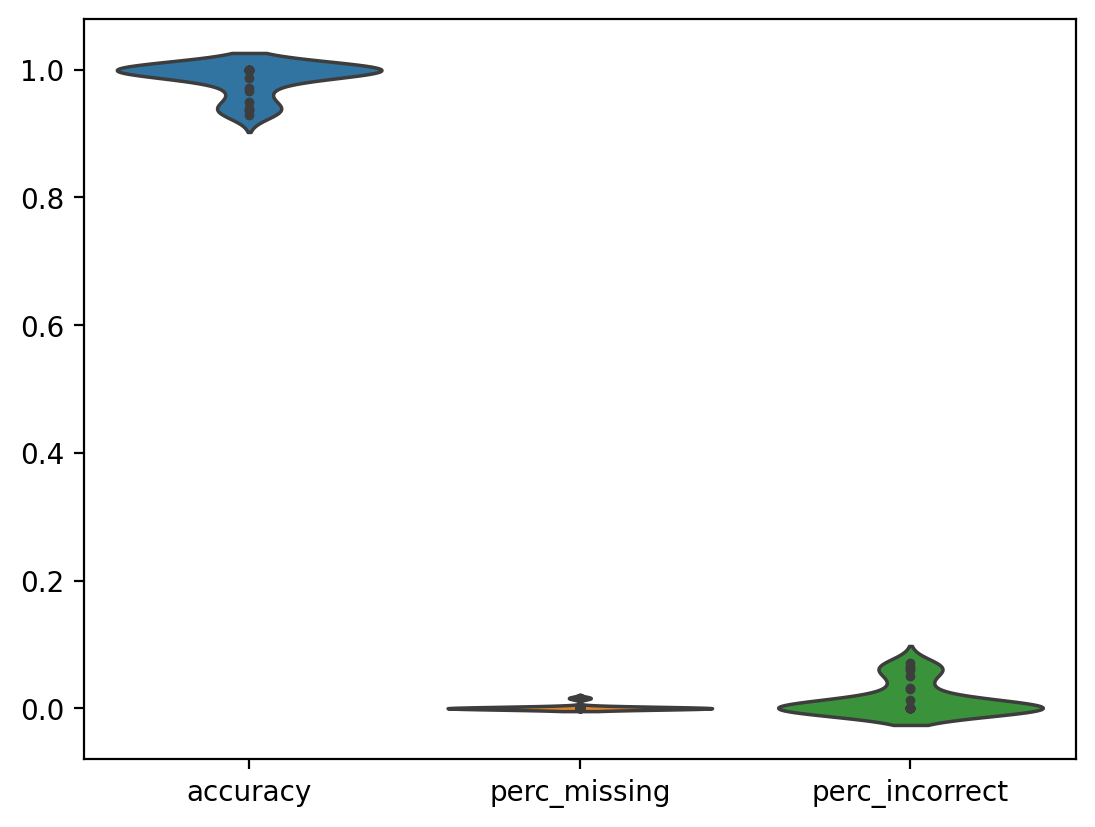

In [9]:
sns.violinplot(data=df[['accuracy', 'perc_missing', 'perc_incorrect']], inner='point')

### Sternhold and Hopkins

In [7]:
def process_SH_work(source_fn, version=None):
    id = os.path.basename(source_fn).split('.')[0]
    score = music21.converter.parse(source_fn)
    return process_stream(
        score, 
        style='english',
        target_lyrics=2,
        annot_kws = dict(lyric_offset=3, grey_lyrics_num=1),
        title=f'SH — Psalm {id[2:]}',
        version=version
    )

# source_fn = f'{SH_DIR}/musicxml/SH001.musicxml'
# score, _, eval = process_SH_work(source_fn)

In [8]:
sh_meta = yaml.safe_load(open(f'{SH_DIR}/collection.yaml', 'r'))
sh_files = []
for works in sh_meta['works']:
    sh_files.append(f"{SH_DIR}/musicxml/{works['id']}.musicxml")

batch_process(
    source_files = sh_files, 
    target_dir = f'{SH_DIR}/evaluation', 
    processor=process_SH_work,
    refresh=True)

In [9]:
sh_df, sh_evaluation = load_evaluation(f'{SH_DIR}/evaluation/evaluation.yaml')
sh_df.describe()

Total number of notes: 56.0
Total number of correct notes: 56.0 (100%)
Total number of errors: 0.0 (0%)
Works with >= 100% accuracy: 1 (100%)
Works with >= 95.0% accuracy: 1 (100%)
Works with >= 90.0% accuracy: 1 (100%)
Works with >= 85.0% accuracy: 1 (100%)
Works with >= 80.0% accuracy: 1 (100%)


,accuracy,correct,deletion,incorrect,insertion,missing,num_notes,num_syllables,perc_incorrect,perc_missing
count,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
mean,1.0,56.0,0.0,0.0,0.0,0.0,56.0,56.0,0.0,0.0
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,1.0,56.0,0.0,0.0,0.0,0.0,56.0,56.0,0.0,0.0
25%,1.0,56.0,0.0,0.0,0.0,0.0,56.0,56.0,0.0,0.0
50%,1.0,56.0,0.0,0.0,0.0,0.0,56.0,56.0,0.0,0.0
75%,1.0,56.0,0.0,0.0,0.0,0.0,56.0,56.0,0.0,0.0
max,1.0,56.0,0.0,0.0,0.0,0.0,56.0,56.0,0.0,0.0


In [10]:
sh_df

,accuracy,correct,deletion,incorrect,insertion,missing,num_notes,num_syllables,perc_incorrect,perc_missing
SH001,1.0,56.0,0.0,0.0,0.0,0.0,56.0,56.0,0.0,0.0


### Smith

In [21]:
def process_smith_work(source_fn, version=None):
    score = music21.converter.parse(source_fn)
    id = os.path.basename(source_fn).split('.')[0]
    piece, voice = id.split('-')
    return process_stream(
        score, 
        style='continental',
        target_lyrics=1,
        annot_kws = dict(lyric_offset=3),
        title=f'{piece.title()} {voice.lower()}',
        version=version
    )

# source_fn = f'{SMITH_DIR}/musicxml/goudimel-Alto.musicxml'
# score, _, eval = process_smith_work(source_fn)

In [22]:
smith_meta = yaml.safe_load(open(f'{SMITH_DIR}/collection.yaml', 'r'))
smith_files = []
for works in smith_meta['works']:
    smith_files.append(f"{SMITH_DIR}/musicxml/{works['id']}.musicxml")

batch_process(
    source_files = smith_files, 
    target_dir = f'{SMITH_DIR}/evaluation', 
    processor=process_smith_work,
    remove_musicxml=False,
    refresh=True)

An error occurred processing /Users/bas/surfdrive/Research/Guidonian Hand/Corpus/Smith/musicxml/isaac-Tenor.musicxml


In [14]:
smith_df, smith_evaluation = load_evaluation(f'{SMITH_DIR}/evaluation/evaluation.yaml')
smith_df.describe()

Total number of notes: 413.0
Total number of correct notes: 392.0 (95%)
Total number of errors: 21.0 (5%)
Works with >= 100% accuracy: 2 (29%)
Works with >= 95.0% accuracy: 4 (57%)
Works with >= 90.0% accuracy: 6 (86%)
Works with >= 85.0% accuracy: 6 (86%)
Works with >= 80.0% accuracy: 7 (100%)


,accuracy,correct,deletion,incorrect,insertion,missing,num_notes,num_syllables,perc_incorrect,perc_missing
count,7.000000,7.00000,7.0,7.00000,7.0,7.0,7.000000,7.000000,7.000000,7.0
mean,0.949366,56.00000,0.0,3.00000,0.0,0.0,59.000000,59.000000,0.050634,0.0
std,0.065523,5.09902,0.0,3.91578,0.0,0.0,3.605551,3.605551,0.065523,0.0
min,0.816667,49.00000,0.0,0.00000,0.0,0.0,56.000000,56.000000,0.000000,0.0
25%,0.930952,53.50000,0.0,0.50000,0.0,0.0,56.000000,56.000000,0.007576,0.0
50%,0.982143,56.00000,0.0,1.00000,0.0,0.0,59.000000,59.000000,0.017857,0.0
75%,0.992424,57.50000,0.0,4.00000,0.0,0.0,60.000000,60.000000,0.069048,0.0
max,1.000000,65.00000,0.0,11.00000,0.0,0.0,66.000000,66.000000,0.183333,0.0


In [15]:
smith_df

,accuracy,correct,deletion,incorrect,insertion,missing,num_notes,num_syllables,perc_incorrect,perc_missing
goudimel-Alto,1.000000,56.0,0.0,0.0,0.0,0.0,56.0,56.0,0.000000,0.0
goudimel-Bass,0.982143,55.0,0.0,1.0,0.0,0.0,56.0,56.0,0.017857,0.0
goudimel-Soprano,1.000000,59.0,0.0,0.0,0.0,0.0,59.0,59.0,0.000000,0.0
goudimel-Tenor,0.928571,52.0,0.0,4.0,0.0,0.0,56.0,56.0,0.071429,0.0
isaac-Alto,0.984848,65.0,0.0,1.0,0.0,0.0,66.0,66.0,0.015152,0.0
isaac-Bass,0.816667,49.0,0.0,11.0,0.0,0.0,60.0,60.0,0.183333,0.0
isaac-Soprano,0.933333,56.0,0.0,4.0,0.0,0.0,60.0,60.0,0.066667,0.0


In [6]:
goudimel_fn = f'{SMITH_DIR}/musicxml/goudimel.musicxml'
isaac_fn = f'{SMITH_DIR}/musicxml/isaac.musicxml'
smith_files = dict(goudimel=goudimel_fn, isaac= isaac_fn)
target_dir = f'{SMITH_DIR}/evaluation', 
for name, source_fn in smith_files.items():
    score = music21.converter.parse(source_fn)
    evaluations = []
    for part in score.parts:
        try: 
            solmization = solmize(part, style="continental")
            solmization.annotate(target_lyrics=1, best_only=True)
            evaluations.append(solmization.evaluate(target_lyrics=1))
        except Exception as e:
            print('skipping part...', part, e)

    target_pdf = f'{SMITH_DIR}/evaluation/{name}.pdf'
    score.write('musicxml.pdf', target_pdf)
    os.remove(f'{SMITH_DIR}/evaluation/{name}.musicxml')

skipping part... <music21.stream.Part Tenor> Source and target pitches are not in the gamut, even when ignoring accidentals.


### **TO DO** Other collectionsdp

In [6]:
target_dir = 'evaluation'
refresh = True

sources = glob.glob(f'{CORPUS_DIR}/**')
for source_dir in sources[2:3]:
    files = sorted(glob.glob(f'{source_dir}/musicxml/*.musicxml'))
    if not os.path.exists(f'{source_dir}/{target_dir}'):
        os.makedirs(f'{source_dir}/{target_dir}')
    for file in files:
        name, _ =  os.path.basename(file).split('.')
        target_fn = f'{source_dir}/{target_dir}/{name}.pdf'
        if not os.path.exists(target_fn) or refresh:
            try:
                score = converter.parse(file)
                evaluateScore(score, onlyBest=False)
                score.write('musicxml.pdf', target_fn)
            except Exception as e:
                print('Skipped', file)
        

Error annotating note <music21.note.Note G>
Error annotating note <music21.note.Note F>
Error annotating note <music21.note.Note A>
Error annotating note <music21.note.Note E>
